# Lista de Exercícios 3: Aproximação de Funções

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido **antes** de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps3.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 05/06/2025. **Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.**
- ***SUBMISSÕES QUE NÃO SEGUIREM ESTAS INSTRUÇÕES NÃO SERÃO AVALIADAS.***
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Mountain Car

Mountain Car é um ambiente no qual um agente precisa conduzir um carro até o topo de uma montanha. No entanto, o motor do carro não é potente o suficiente para subir diretamente até o topo. Por isso, o agente precisa aprender a aproveitar o impulso - movendo-se para frente e para trás - para ganhar velocidade suficiente e alcançar o topo.

![](https://gymnasium.farama.org/_images/mountain_car.gif)

O espaço de observação é contínuo e composto por dois valores: a posição e a velocidade do carro. O agente pode escolher entre três ações discretas: acelerar o carro para a esquerda, acelerar para a direita, ou não acelerar. A posição inicial do agente é definida de forma uniformemente aleatória no intervalo $[-0.6, -0.4]$. O episódio se encerra quando o carro atinge o topo da montanha à direita (posição $0.5$) ou quando o limite de 200 passos é atingido. A cada passo, o agente recebe uma penalidade de $-1$, incentivando-o a alcançar o objetivo no menor número possível de passos. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Devido à natureza contínua do espaço de estados, métodos tabulares não são eficazes. Assim, é comum o uso de técnicas de aproximação de função para solucionar o problema de forma eficiente. Nesta lista de exercícios, você irá trabalhar com o ambiente Mountain Car descrito acima. Seu objetivo será implementar o algoritmo *Semi-Gradient Episodic Sarsa* com aproximação linear e explorar como diferentes técnicas de construção de features influenciam o desempenho do agente.

## Semi-Gradient Episodic Sarsa

Nesta atividade, você implementará um agente baseado no algoritmo Semi-Gradient Episodic SARSA, utilizando uma **função de valor linear**.

Antes de iniciar sua implementação, analise a interface `FeatureExtractor` fornecida abaixo. Ela será a base para os construtores de features que você implementará na próxima seção. O agente utilizará um objeto com essa interface para extrair features a partir das observações dos estados.

In [108]:
from abc import ABC, abstractmethod

import numpy as np
import gymnasium as gym
import sklearn
import matplotlib.pyplot as plt

In [109]:
class FeatureExtractor(ABC):
    """
    Interface for feature extractors that convert environment states into feature vectors.
    """

    @property
    @abstractmethod
    def feature_size(self):
        """
        Property that returns the size of the feature vector produced by this extractor.

        Returns:
            An integer representing the length of the feature vector.
        """
        pass

    @abstractmethod
    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector.

        Args:
            state: The observation state from the environment.

        Returns:
            The extracted feature vector representation.
        """
        pass

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, um construtor de features (`feature_extractor`), a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$. Inicialize os pesos do modelo na variável `self.weights`.
2. Implemente o método `compute_q_values`, que recebe um vetor de features e calcula os *Q-values* de acordo com a entrada.
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [110]:
class SGESAgent:
    def __init__(self, observation_space, action_space, feature_extractor, alpha=0.01, gamma=0.99, epsilon=0.1):
        self.observation_space = observation_space
        self.action_space = action_space
        self.feature_extractor = feature_extractor
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.weights = np.zeros((action_space.n, feature_extractor.feature_size))


    def compute_q_values(self, features):
        return np.dot(self.weights, features)


    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()  # Explore
        else:
            features = self.feature_extractor.extract(state)
            return np.argmax(self.compute_q_values(features))  # Exploit


    def learn(self, state, action, reward, next_state, next_action, done):
        features = self.feature_extractor.extract(state)
        next_features = self.feature_extractor.extract(next_state)

        if done:
            self.weights[action] += self.alpha * (reward - self.compute_q_values(features)[action]) * features
        else:
            td_target = reward + self.gamma * self.compute_q_values(next_features)[next_action]
            td_error = td_target - self.compute_q_values(features)[action]
            self.weights[action] += self.alpha * td_error * features


    def train(self, env, episodes=500):
        rewards = []
        for _ in range(episodes):
            state, _ = env.reset()
            total_reward = 0
            done = False
            action = self.choose_action(state)

            while not done:
                next_state, reward, done, _, _ = env.step(action)
                next_action = self.choose_action(next_state)

                self.learn(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action
                total_reward += reward

            rewards.append(total_reward)
        return rewards

In [111]:
# Não altere ou remova esta célula

In [112]:
# Não altere ou remova esta célula

In [113]:
# Não altere ou remova esta célula

In [114]:
# Não altere ou remova esta célula

In [115]:
# Não altere ou remova esta célula

## Construção de Features

Com o algoritmo do agente pronto, você deverá implementar 3 modelos de construtores de features diferentes:

1. **Modelo Identidade**
2. **Modelo Tile Coding**
3. **Modelo de Funções de Base Radial**

### Identidade

6. Implemente o `IdentityFeatureExtractor`, cujo método `extract` apenas retorna a observação de entrada, sem realizar nenhuma operação nela.

In [116]:
class IdentityFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space):
        self.observation_space = observation_space

    @property
    def feature_size(self):
        return self.observation_space.shape[0]

    def extract(self, state):
        return state

In [117]:
# Não altere ou remova esta célula

7. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `IdentityFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `identity_agent`.

In [118]:
env = gym.make("MountainCar-v0")

feature_extractor = IdentityFeatureExtractor(env.observation_space)
agent = SGESAgent(env.observation_space, env.action_space, feature_extractor, alpha=0.01, gamma=0.99, epsilon=0.1)
identity_agent = agent.train(env, episodes=200)

env.close()

In [119]:
# Não altere ou remova esta célula

### Tile Coding

8. Implemente o `TileCodingFeatureExtractor`, cujo método `extract` gera um vetor de features utilizando a técnica de *tile coding*. A quantidade de tilings a ser gerada é definida pelo parâmetro `num_tilings`, enquanto a quantidade de divisões por dimensão em cada tiling é definida pelo parâmetro `tiles_per_dim`. Ambos valores são fornecidos ao construtor da classe. Por exemplo: um `TileCodingFeatureExtractor` com `num_tilings = 3` e `tiles_per_dim = 2` deve gerar 3 tilings, cada um dividindo o espaço em uma grade de tamanho 2 $\times$ 2.

**Importante:** Após a implementação, realize experimentos variando os valores de `num_tilings` e `tiles_per_dim` para identificar as configurações que resultam em melhor desempenho de aprendizado.

In [120]:
class TileCodingFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, num_tilings, tiles_per_dim):
        self.observation_space = observation_space
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim

        self.dimensions = len(observation_space.low)
        self.bins = np.full((2, ), self.tiles_per_dim)

        self.offsets = [
            (np.arange(self.dimensions) + 1) * (i / self.num_tilings)
            for i in range(self.num_tilings)
        ]

        self.tile_width = (self.observation_space.high - self.observation_space.low) / (self.bins - 1)


    @property
    def feature_size(self):
        return self.num_tilings * np.prod(self.bins)


    def extract(self, state):
        state = np.array(state)
        features = np.zeros(self.feature_size)

        for i, offset in enumerate(self.offsets):
            indices = ((state - self.observation_space.low + offset * self.tile_width) / self.tile_width).astype(int)
            indices = np.clip(indices, 0, self.bins - 1)

            tile_index = np.ravel_multi_index(indices, self.bins)
            feature_index = i * np.prod(self.bins) + tile_index
            features[feature_index] = 1.0

        return features


In [121]:
# Não altere ou remova esta célula

9. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `TileCodingFeatureExtractor` com `num_tilings = 6` e `tiles_per_dim = 6`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `tile_agent`.

In [122]:
env = gym.make("MountainCar-v0")

feature_extractor = TileCodingFeatureExtractor(env.observation_space, num_tilings=8, tiles_per_dim=8)
agent = SGESAgent(env.observation_space, env.action_space, feature_extractor, alpha=0.01, gamma=0.99, epsilon=0.1)
tile_agent = agent.train(env, episodes=200)

env.close()

In [123]:
# Não altere ou remova esta célula

### Funções de Base Radial

10. Implemente o `RBFFeatureExtractor`, cujo método `extract` gera um conjunto de features baseadas em *Radial Basis Functions*. A quantidade total de componentes a ser gerada é definida pelo parâmetro `n_components`, fornecido ao construtor da classe. Utilize a biblioteca *scikit-learn* (sklearn) para auxiliar sua implementação.

**Importante:** Você pode combinar RBFs com diferentes parâmetros para capturar melhor dinâmicas complexas do ambiente e potencialmente melhorar o desempenho do agente. Após a implementação, realize experimentos variando essas configurações para identificar as combinações que produzem os melhores resultados de aprendizado. Normalizar o vetor de entrada também pode facilitar o aprendizado.

In [124]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler

class RBFFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, n_components):
        self.n_components = n_components
        self.observation_space = observation_space

        self.scaler = StandardScaler()
        sample_states = self._sample_states()
        self.scaler.fit(sample_states)

        self.rbf_sampler = RBFSampler(gamma=1.0, n_components=n_components, random_state=42)
        self.rbf_sampler.fit(self.scaler.transform(sample_states))

    def _sample_states(self, n_samples=10000):
        low = self.observation_space.low
        high = self.observation_space.high
        return np.random.uniform(low, high, size=(n_samples, low.shape[0]))


    @property
    def feature_size(self):
        return self.n_components


    def extract(self, state):
        state = np.array(state).reshape(1, -1)
        state_scaled = self.scaler.transform(state)
        return self.rbf_sampler.transform(state_scaled)[0]

In [125]:
# Não altere ou remova esta célula

11. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `RBFFeatureExtractor` com 100 componentes. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `rbf_agent`.

In [126]:
env = gym.make("MountainCar-v0")

feature_extractor = RBFFeatureExtractor(env.observation_space, n_components=100)
agent = SGESAgent(env.observation_space, env.action_space, feature_extractor, alpha=0.01, gamma=0.99, epsilon=0.1)
rbf_agent = agent.train(env, episodes=200)

env.close()

In [127]:
# Não altere ou remova esta célula

## Análise

12. Utilize a biblioteca matplotlib para construir um gráfico comparativo dos retornos episódicos obtidos pelos agentes utilizando cada um dos construtores de features implementados. Utilize as variáveis `identity_agent`, `poly_agent` e `rbf_agent` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Caso seja necessário, aplique uma média movel para suavizar as curvas e deixar as tendências mais evidentes. Inclua título, legendas e rótulos de eixos apropriados para facilitar a interpretação. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

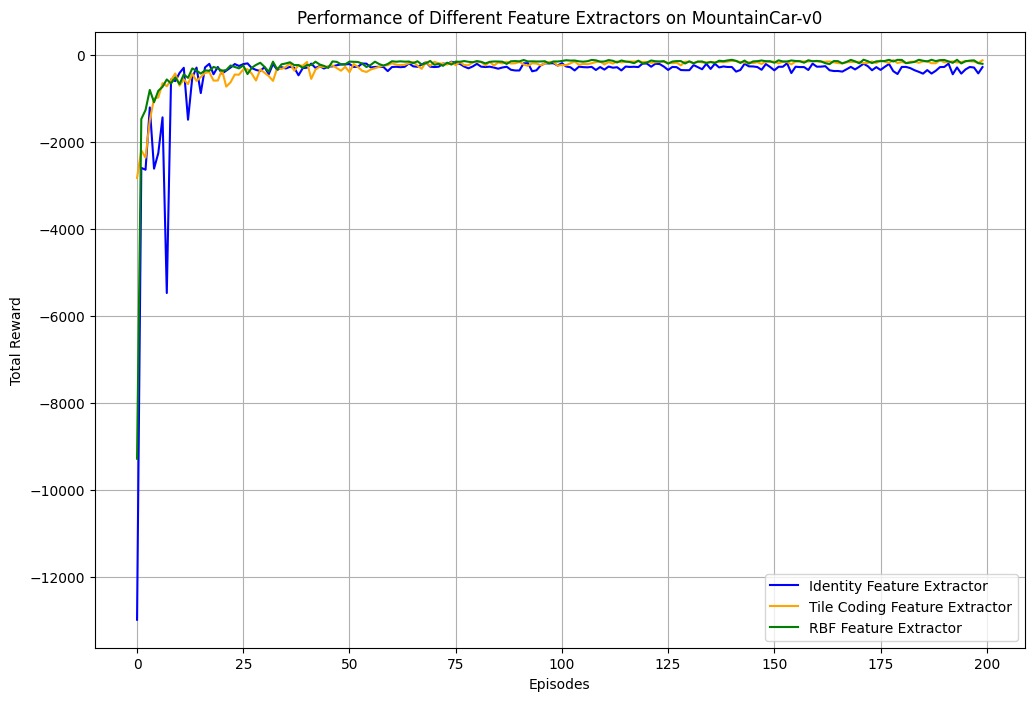

In [128]:
plt.figure(figsize=(12, 8))
plt.plot(identity_agent, label='Identity Feature Extractor', color='blue')
plt.plot(tile_agent, label='Tile Coding Feature Extractor', color='orange')
plt.plot(rbf_agent, label='RBF Feature Extractor', color='green')
plt.title('Performance of Different Feature Extractors on MountainCar-v0')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()
plt.show()

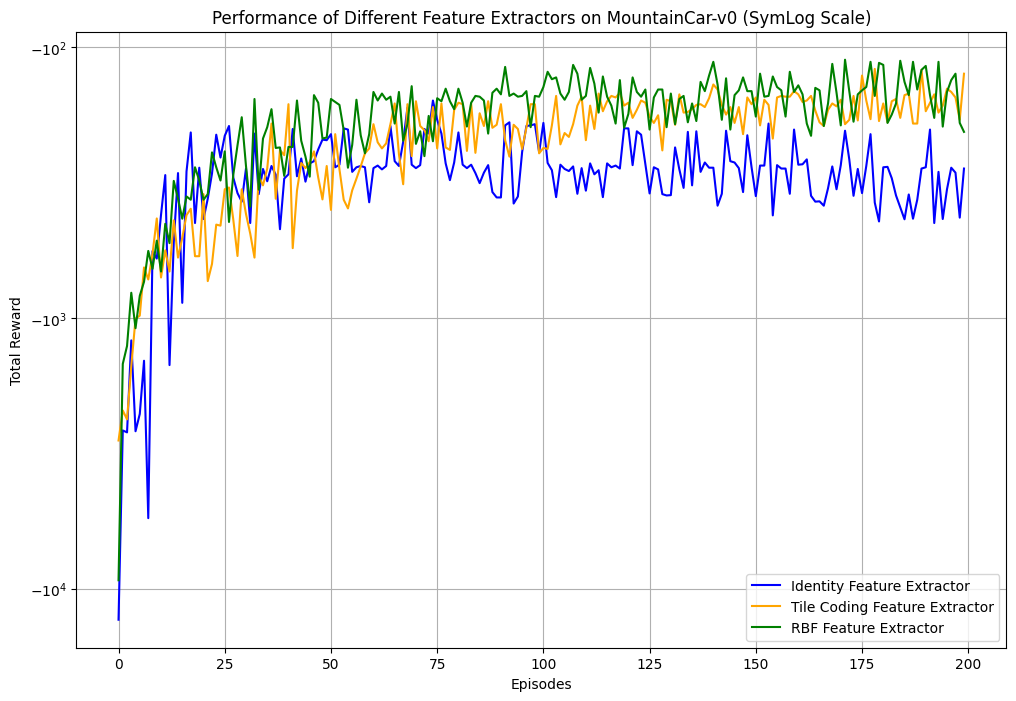

In [131]:
plt.figure(figsize=(12, 8))
plt.plot(identity_agent, label='Identity Feature Extractor', color='blue')
plt.plot(tile_agent, label='Tile Coding Feature Extractor', color='orange')
plt.plot(rbf_agent, label='RBF Feature Extractor', color='green')
plt.title('Performance of Different Feature Extractors on MountainCar-v0 (SymLog Scale)')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.yscale('symlog', linthresh=1)
plt.legend()
plt.grid()
plt.show()

13. Explique por que a modelagem do construtor de features pode ser crucial para o desempenho de um agente que utiliza aproximação de função.

YOUR ANSWER HERE

14. Quais critérios devem guiar a escolha dos modelos e da quantidade de features a serem utilizadas na construção do espaço de features?

YOUR ANSWER HERE